In [87]:
import numpy
import os
import json
import csv
import pandas as pd
import numpy as np
np.random.seed(42)

In [88]:
path = "../data"

In [89]:
file = "Sorted_combined.csv"

In [90]:
data = pd.read_csv(os.path.join(path,file),header=None)
unbalancedData = pd.read_csv(os.path.join(path,file),header=None)

In [91]:
data.head()

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
0,1.554536e+09,-1.647343,-1.956522,-1.562802,-1.115942,-1.084541,-1.118357,-0.971014,127.000000,-0.979311,...,0.081189,-0.146538,-0.239349,0.136632,-0.960292,-1.289528,-0.144415,0.17516,0,Kuntal
1,1.554536e+09,-1.647343,-1.956522,-1.562802,-1.115942,-1.084541,-1.118357,-0.971014,127.000000,-0.979311,...,0.081189,-0.146538,-0.239349,0.136632,-0.960292,-1.289528,-0.144415,0.17516,0,Shailaja
2,1.554536e+09,-2.745819,-3.035117,-3.526756,-1.448161,-1.683946,-0.836120,-0.968227,-32.822742,-0.980840,...,0.080267,-0.141640,-0.224180,0.139840,-0.964293,-1.098293,0.004593,0.57038,0,Kuntal
3,1.554536e+09,-2.745819,-3.035117,-3.526756,-1.448161,-1.683946,-0.836120,-0.968227,-32.822742,-0.980840,...,0.080267,-0.141640,-0.224180,0.139840,-0.964293,-1.098293,0.004593,0.57038,0,Shailaja
4,1.554536e+09,-1.618333,-1.761667,-1.893333,-1.003333,-0.115000,-0.823333,-0.950000,-122.951667,-0.979620,...,0.075060,-0.145587,-0.242633,0.124593,-0.961480,-1.113340,-0.805847,0.17794,0,Kuntal


In [92]:
noneatData = data[data[data.columns[19]]==0]

In [93]:
eatData = data[data[data.columns[19]]==1]

In [94]:
noneatData = noneatData.sample(n=3181)

In [95]:
print(noneatData.shape,eatData.shape)

(3181, 21) (3181, 21)


### Data Vectorization

In [96]:
data = pd.concat([noneatData,eatData])

In [97]:
X_data = np.array(data[data.columns[1:19]].values.tolist())
X_unbalancedData = np.array(unbalancedData[unbalancedData.columns[1:19]].values.tolist())

In [98]:
#data[data.columns[19]].head()

In [99]:
print (X_data.shape,X_unbalancedData.shape)

(6362, 18) (77670, 18)


In [100]:
Y_data = np.array(data[data.columns[19]].values.tolist())
Y_unbalancedData = np.array(unbalancedData[unbalancedData.columns[19]].values.tolist())

In [101]:
print(Y_data.shape,Y_unbalancedData.shape)

(6362,) (77670,)


### Feature Selection

#### L1-based feature selection

In [102]:
from sklearn.feature_selection import SelectFromModel
from sklearn.svm import LinearSVC

In [103]:
lsvc = LinearSVC(C=0.01, penalty="l1", dual=False).fit(X_data, Y_data)
model = SelectFromModel(lsvc, prefit=True)
X_new = model.transform(X_data)
X_new.shape

(6362, 15)

#### Tree-based feature selection (Works very good)

In [104]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel

clfTree = ExtraTreesClassifier(n_estimators=50)
clfTree = clfTree.fit(X_data, Y_data)
print (clfTree.feature_importances_)  

model = SelectFromModel(clfTree, prefit=True)
X_new = model.transform(X_data)
print (X_new.shape)

[0.02592491 0.03590405 0.03991734 0.03009579 0.03024977 0.03312345
 0.0342882  0.06424394 0.17438478 0.06360691 0.06849943 0.07875936
 0.08317107 0.06190636 0.09000751 0.02931372 0.02859734 0.02800603]
(6362, 8)


In [125]:
X_unbalanced_new = model.transform(X_unbalancedData)
print(X_unbalanced_new.shape)

(77670, 8)


### Classification

In [105]:
from sklearn.svm import SVC

In [106]:
clf = SVC(gamma='auto')

In [107]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_new, Y_data, test_size=0.30, random_state=42, shuffle =True)

In [108]:
print (y_train)

[1 1 1 ... 1 1 0]


In [109]:
clf.fit(X_train,y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [110]:
from sklearn.metrics import accuracy_score
preds_val = clf.predict(X_test)
accuracy = accuracy_score(y_test, preds_val)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 83.55%


#### Parameter Search by GridSearch

In [111]:
from sklearn.model_selection import GridSearchCV

def svc_param_selection(XData, yData, nfolds):
    Cs = [0.001, 0.01, 0.1, 1, 10]
    gammas = [0.001, 0.01, 0.1, 1]
    kernels = ["linear", "rbf","sigmoid"]
    #kernels = ["linear"]
    param_grid = {'C': Cs, 'gamma' : gammas, 'kernel' : kernels}
    grid_search = GridSearchCV(SVC(cache_size=2000), param_grid, cv=nfolds, n_jobs=-1, verbose=2)
    grid_search.fit(XData, yData)
    grid_search.best_params_
    return grid_search.best_params_

In [112]:
best_params = svc_param_selection(X_train,y_train,5)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   23.0s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 10.6min finished


In [113]:
best_params

{'C': 10, 'gamma': 1, 'kernel': 'rbf'}

In [ ]:
clf = SVC(gamma=best_params['gamma'], C=best_params['C'], kernel = best_params['kernel'])
#clf = SVC(gamma=0.001, C=0.1, kernel = 'linear')

In [115]:
clf.fit(X_train,y_train)

SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=1, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

#### Testing Accuracy

In [116]:
preds_val = clf.predict(X_test)
accuracy = accuracy_score(y_test, preds_val)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 87.17%


In [117]:
from sklearn.metrics import confusion_matrix

In [118]:
confusion_matrix(y_test, preds_val)

array([[835, 127],
       [118, 829]])

In [119]:
preds_val.shape

(1909,)

In [120]:
from sklearn.utils.multiclass import unique_labels
import matplotlib.pyplot as plt
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

Confusion matrix, without normalization
[[835 127]
 [118 829]]


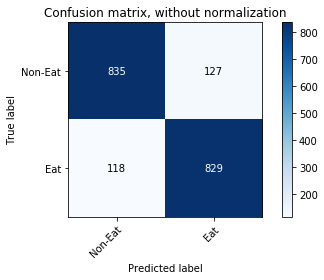

In [121]:
plot_confusion_matrix(y_test, preds_val,np.array(['Non-Eat','Eat']))

#### Testing with Unbalanced data (77670 samples)

In [131]:
print(X_unbalanced_new.shape)
preds_val_unbalanced = clf.predict(X_unbalanced_new)
accuracy = accuracy_score(Y_unbalancedData, preds_val_unbalanced)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

(77670, 8)
Accuracy: 85.39%


Confusion matrix, without normalization
[[63360 11129]
 [  222  2959]]


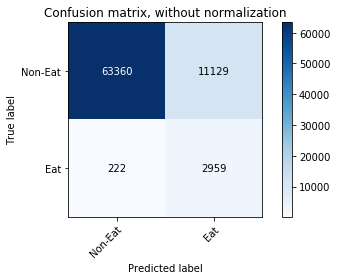

In [132]:
plot_confusion_matrix(Y_unbalancedData, preds_val_unbalanced,np.array(['Non-Eat','Eat']))

### Training Accuracy

In [133]:
print(X_train.shape)
preds_val_train = clf.predict(X_train)
accuracy = accuracy_score(y_train, preds_val_train)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

(4453, 8)
Accuracy: 93.98%


Confusion matrix, without normalization
[[2055  164]
 [ 104 2130]]


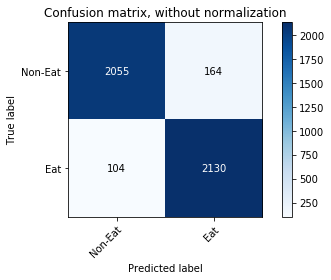

In [134]:
plot_confusion_matrix(y_train, preds_val_train,np.array(['Non-Eat','Eat']))

## Random Forest

In [135]:
from  sklearn.ensemble import RandomForestClassifier
model1 = RandomForestClassifier(random_state=0)

In [155]:
from sklearn.model_selection import GridSearchCV
parameters = {'n_estimators':(5,10,20), 
              'max_depth': range(1, 10, 5),
             }
    

In [156]:
model1.get_params().keys()

dict_keys(['cv', 'error_score', 'estimator__bootstrap', 'estimator__class_weight', 'estimator__criterion', 'estimator__max_depth', 'estimator__max_features', 'estimator__max_leaf_nodes', 'estimator__min_impurity_decrease', 'estimator__min_impurity_split', 'estimator__min_samples_leaf', 'estimator__min_samples_split', 'estimator__min_weight_fraction_leaf', 'estimator__n_estimators', 'estimator__n_jobs', 'estimator__oob_score', 'estimator__random_state', 'estimator__verbose', 'estimator__warm_start', 'estimator', 'fit_params', 'iid', 'n_jobs', 'param_grid', 'pre_dispatch', 'refit', 'return_train_score', 'scoring', 'verbose'])

In [157]:
gs_clf = GridSearchCV(RandomForestClassifier(random_state=0),parameters, cv=5, n_jobs=1,verbose=2)

In [158]:
print (X_train.shape, y_train.shape)
model = gs_clf.fit(X_train, y_train)

(4453, 8) (4453,)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] max_depth=1, n_estimators=5 .....................................
[CV] ...................... max_depth=1, n_estimators=5, total=   0.0s
[CV] max_depth=1, n_estimators=5 .....................................
[CV] ...................... max_depth=1, n_estimators=5, total=   0.0s
[CV] max_depth=1, n_estimators=5 .....................................
[CV] ...................... max_depth=1, n_estimators=5, total=   0.0s
[CV] max_depth=1, n_estimators=5 .....................................
[CV] ...................... max_depth=1, n_estimators=5, total=   0.0s
[CV] max_depth=1, n_estimators=5 .....................................
[CV] ...................... max_depth=1, n_estimators=5, total=   0.0s
[CV] max_depth=1, n_estimators=10 ....................................
[CV] ..................... max_depth=1, n_estimators=10, total=   0.0s
[CV] max_depth=1, n_estimators=10 ....................................

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] ..................... max_depth=1, n_estimators=10, total=   0.0s
[CV] max_depth=1, n_estimators=10 ....................................
[CV] ..................... max_depth=1, n_estimators=10, total=   0.0s
[CV] max_depth=1, n_estimators=10 ....................................
[CV] ..................... max_depth=1, n_estimators=10, total=   0.0s
[CV] max_depth=1, n_estimators=10 ....................................
[CV] ..................... max_depth=1, n_estimators=10, total=   0.0s
[CV] max_depth=1, n_estimators=20 ....................................
[CV] ..................... max_depth=1, n_estimators=20, total=   0.1s
[CV] max_depth=1, n_estimators=20 ....................................
[CV] ..................... max_depth=1, n_estimators=20, total=   0.1s
[CV] max_depth=1, n_estimators=20 ....................................
[CV] ..................... max_depth=1, n_estimators=20, total=   0.1s
[CV] max_depth=1, n_estimators=20 ....................................
[CV] .

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    2.1s finished


In [159]:
print(model.best_params_)
for param_name in sorted(parameters.keys()):
    print("%s: %r" % (param_name, model.best_params_[param_name]))

{'max_depth': 6, 'n_estimators': 20}
max_depth: 6
n_estimators: 20


In [160]:
from sklearn.metrics import accuracy_score
preds_val = model.predict(X_test)
accuracy = accuracy_score(y_test, preds_val)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 84.23%


Confusion matrix, without normalization
[[809 153]
 [148 799]]


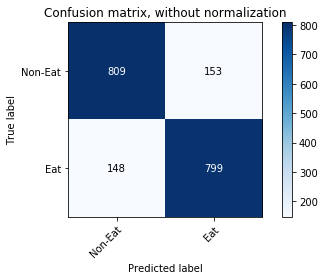

In [161]:
plot_confusion_matrix(y_test, preds_val,np.array(['Non-Eat','Eat']))

#### Training Accuracy

In [163]:
from sklearn.metrics import accuracy_score
preds_val_train = model.predict(X_train)
accuracy = accuracy_score(y_train, preds_val_train)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 84.19%


Confusion matrix, without normalization
[[1842  377]
 [ 327 1907]]


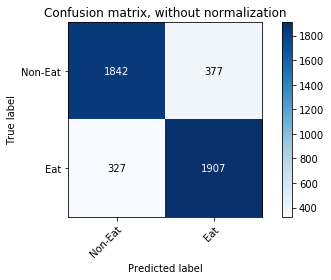

In [164]:
plot_confusion_matrix(y_train, preds_val_train,np.array(['Non-Eat','Eat']))

#### Test with unbalanced data

In [166]:
from sklearn.metrics import accuracy_score
preds_val = model.predict(X_unbalanced_new)
accuracy = accuracy_score(Y_unbalancedData, preds_val)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 81.13%


Confusion matrix, without normalization
[[60310 14179]
 [  475  2706]]


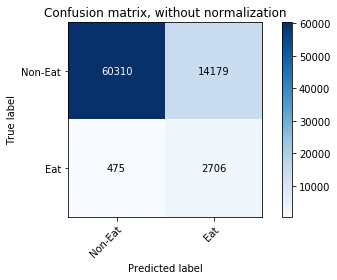

In [167]:
plot_confusion_matrix(Y_unbalancedData, preds_val,np.array(['Non-Eat','Eat']))